### Load experiment meta-data

In [14]:
from sumo_python.helpers.load_experiment_metadata import load_experiment_config

In [2]:
input_path = "/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/"

In [3]:
config, sim_setup = load_experiment_config(config=input_path + 'config.json',
                        sim_setup=input_path + 'simulation_setups.json',)

In [15]:
config

{'NETWORK': PosixPath('/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data'),
 'SUMO': PosixPath('/usr/local/opt/sumo/share/sumo')}

# Run simulations

Steps:
1. Create OD meta-files that for a given count, creates a random trajectoy of vehicles moving from O -> D
2. Run SUMO against the latter files
3. Parse output of simulation and yields the aggregated value of vehicles which arrive to a given node in th network



### Step 1. Create OD meta-data

In [5]:
import numpy as np
from sumo_python.helpers.generate_od_xml import generate_od_xml


prefix_run = 'iter'
#od_rand = np.random.rand(4)*200
od_rand = np.array([500,500,900,900])
#print(prefix_run, np.sum(od_rand))
    
generate_od_xml(od_rand, config, sim_setup, prefix_run)


printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml


### Step 2-3: Run SUMO and parse output

In [6]:
from sumo_python.simulator.run_sumo_and_parse_output import run_sumo_and_parse_output

df_simulated = run_sumo_and_parse_output(config, sim_setup, prefix_run)


### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (10ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (3ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5ms ~= 200.00*RT, ~131200.00UPS, vehicles TOT 2800 ACT 656 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simula

In [7]:
df_simulated

,EdgeID,interval_begin,interval_end,interval_nVehContrib,interval_harmonicMeanSpeed
0,#EdgeL5,54000.0,57600.0,959.0,13.500000
1,#EdgeL7,54000.0,57600.0,1243.0,13.603333


In [64]:
df_simulated

,EdgeID,interval_begin,interval_end,interval_nVehContrib,interval_harmonicMeanSpeed
0,#EdgeL5,54000.0,57600.0,319.666667,13.500000
1,#EdgeL7,54000.0,57600.0,414.333333,13.603333


### Obtain ground-truth

In [8]:
from sumo_python.simulator.ground_truth import run_ground_truth_and_parse
df_gt_data = run_ground_truth_and_parse(config, sim_setup)

od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.gt_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml 
Success.
sumo --output-prefix gt_ --ignore-route-errors=true --net-file=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml --routes=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml -b 54000 -e 57600 --additional-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml --duration-log.statistics --xml-validation never --vehroutes /Users/rodrse/Documents/DemandCalibration/notebooks

In [9]:
df_gt_data

,EdgeID,interval_begin,interval_end,interval_nVehContrib,interval_harmonicMeanSpeed
0,#EdgeL5,54000.0,57600.0,959,13.500000
1,#EdgeL7,54000.0,57600.0,1243,13.603333


# Compute objective

In [10]:
from sumo_python.helpers.nrmse_counts import compute_nrmse_counts

loss_estimate = compute_nrmse_counts(df_gt_data, df_simulated)
loss_estimate

0.0

### wrap objective x -> f(x)

In [16]:
def objective(x):
    
    prefix_run = 'iter'    
    generate_od_xml(x, config, sim_setup, prefix_run)
    df_simulated = run_sumo_and_parse_output(config, sim_setup, prefix_run)
    loss_estimate = compute_nrmse_counts(df_gt_data, df_simulated)
    df_output = pd.DataFrame(x.reshape(-1, len(x)),columns = ['x1','x2','x3','x4'])
    df_output['loss_estimate'] = loss_estimate
    
    return df_output

# Bayesian optimization

In [17]:
import os
import torch
import pandas as pd

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double


### Declare search space

In [18]:
# dimensionality of input space
d = 4 
bounds = torch.tensor([[400,400,400,400],[1000,1000,1000,1000]], device=device, dtype=dtype) 
bounds

tensor([[ 400.,  400.,  400.,  400.],
        [1000., 1000., 1000., 1000.]], dtype=torch.float64)

### Generate batch of policies using Sobol sequences

In [19]:
from torch.quasirandom import SobolEngine
n0 = 25
dim = 4
sobol = SobolEngine(dim, scramble=True)
x_0 = sobol.draw(n0).to(dtype=dtype)

In [20]:
from botorch.utils.transforms import unnormalize
# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)


In [21]:
df_0 = [
    objective(x) for x in train_X0.cpu().detach().numpy()
]

df_0 = pd.concat(df_0)
df_0['iter'] = 0

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (9ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (2ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (7

Step #57600.00 (7ms ~= 142.86*RT, ~98142.86UPS, vehicles TOT 2691 ACT 687 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 16.37s
 Real time factor: 219.874
 UPS: 98077.078116
Vehicles: 
 Inserted: 2691
 Running: 687
 Waiting: 0
 Teleports: 2 (Wrong Lane: 2)
Statistics (avg of 2004):
 RouteLength: 4336.34
 Speed: 12.06
 Duration: 446.45
 WaitingTime: 84.64
 TimeLoss: 132.07
 DepartDelay: 0.50

DijkstraRouter answered 2691 queries and explored 10.06 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/note

Step #57600.00 (10ms ~= 100.00*RT, ~80600.00UPS, vehicles TOT 2865 ACT 806 BUF 344)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 22.94s
 Real time factor: 156.958
 UPS: 99120.029648
Vehicles: 
 Inserted: 2865 (Loaded: 3209)
 Running: 806
 Waiting: 344
 Teleports: 40 (Jam: 25, Wrong Lane: 15)
Statistics (avg of 2059):
 RouteLength: 4473.87
 Speed: 10.88
 Duration: 522.84
 WaitingTime: 101.47
 TimeLoss: 199.18
 DepartDelay: 0.49

DijkstraRouter answered 3294 queries and explored 10.61 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Doc

Step #57600.00 (6ms ~= 166.67*RT, ~142333.33UPS, vehicles TOT 2850 ACT 854 BUF 235)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 21.63s
 Real time factor: 166.436
 UPS: 108309.477577
Vehicles: 
 Inserted: 2850 (Loaded: 3085)
 Running: 854
 Waiting: 235
 Teleports: 18 (Jam: 10, Wrong Lane: 8)
Statistics (avg of 1996):
 RouteLength: 4440.39
 Speed: 10.39
 Duration: 567.53
 WaitingTime: 113.68
 TimeLoss: 245.70
 DepartDelay: 0.46

DijkstraRouter answered 3086 queries and explored 10.42 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Doc

Step #57600.00 (6ms ~= 166.67*RT, ~129333.33UPS, vehicles TOT 2514 ACT 776 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 17.97s
 Real time factor: 200.39
 UPS: 92265.237963
Vehicles: 
 Inserted: 2514
 Running: 776
 Waiting: 0
 Teleports: 2 (Jam: 1, Wrong Lane: 1)
Statistics (avg of 1738):
 RouteLength: 4360.00
 Speed: 12.38
 Duration: 446.25
 WaitingTime: 85.92
 TimeLoss: 130.41
 DepartDelay: 0.49

DijkstraRouter answered 2514 queries and explored 10.68 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibrati

Step #57600.00 (6ms ~= 166.67*RT, ~129833.33UPS, vehicles TOT 2771 ACT 779 BUF 58)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 17.37s
 Real time factor: 207.302
 UPS: 108367.557296
Vehicles: 
 Inserted: 2771 (Loaded: 2829)
 Running: 779
 Waiting: 58
 Teleports: 43 (Jam: 1, Wrong Lane: 42)
Statistics (avg of 1992):
 RouteLength: 4395.96
 Speed: 11.54
 Duration: 474.14
 WaitingTime: 95.82
 TimeLoss: 155.92
 DepartDelay: 0.52

DijkstraRouter answered 2936 queries and explored 10.32 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Docum

Step #57600.00 (10ms ~= 100.00*RT, ~86700.00UPS, vehicles TOT 2743 ACT 867 BUF 229)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 20.28s
 Real time factor: 177.48
 UPS: 102979.589824
Vehicles: 
 Inserted: 2743 (Loaded: 2972)
 Running: 867
 Waiting: 229
 Teleports: 20 (Jam: 11, Wrong Lane: 9)
Statistics (avg of 1876):
 RouteLength: 4394.04
 Speed: 12.48
 Duration: 432.79
 WaitingTime: 78.99
 TimeLoss: 114.07
 DepartDelay: 0.47

DijkstraRouter answered 2973 queries and explored 10.80 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Docum

Step #57600.00 (11ms ~= 90.91*RT, ~75000.00UPS, vehicles TOT 2981 ACT 825 BUF 503)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 28.35s
 Real time factor: 126.984
 UPS: 84290.229277
Vehicles: 
 Inserted: 2981 (Loaded: 3484)
 Running: 825
 Waiting: 503
 Teleports: 25 (Jam: 13, Wrong Lane: 12)
Statistics (avg of 2156):
 RouteLength: 4384.52
 Speed: 11.10
 Duration: 505.92
 WaitingTime: 103.90
 TimeLoss: 187.96
 DepartDelay: 1.07

DijkstraRouter answered 3671 queries and explored 10.19 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Doc

Step #57600.00 (13ms ~= 76.92*RT, ~63846.15UPS, vehicles TOT 3081 ACT 830 BUF 36)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 22.29s
 Real time factor: 161.5
 UPS: 97166.120856
Vehicles: 
 Inserted: 3081 (Loaded: 3117)
 Running: 830
 Waiting: 36
 Teleports: 7 (Wrong Lane: 7)
Statistics (avg of 2251):
 RouteLength: 4350.87
 Speed: 10.74
 Duration: 538.23
 WaitingTime: 105.67
 TimeLoss: 222.79
 DepartDelay: 0.49

DijkstraRouter answered 3127 queries and explored 9.92 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCa

Step #57600.00 (11ms ~= 90.91*RT, ~98363.64UPS, vehicles TOT 3316 ACT 1082 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 25.91s
 Real time factor: 138.948
 UPS: 94918.715504
Vehicles: 
 Inserted: 3316
 Running: 1082
 Waiting: 0
 Teleports: 1 (Yield: 1)
Statistics (avg of 2234):
 RouteLength: 4253.04
 Speed: 10.84
 Duration: 600.19
 WaitingTime: 141.70
 TimeLoss: 292.01
 DepartDelay: 0.48

DijkstraRouter answered 3316 queries and explored 9.74 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebook

Step #57600.00 (10ms ~= 100.00*RT, ~76200.00UPS, vehicles TOT 2336 ACT 762 BUF 240)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 24.56s
 Real time factor: 146.592
 UPS: 79857.276651
Vehicles: 
 Inserted: 2336 (Loaded: 2576)
 Running: 762
 Waiting: 240
 Teleports: 47 (Jam: 8, Wrong Lane: 39)
Statistics (avg of 1574):
 RouteLength: 4475.48
 Speed: 11.85
 Duration: 503.73
 WaitingTime: 126.61
 TimeLoss: 179.21
 DepartDelay: 0.49

DijkstraRouter answered 2576 queries and explored 11.11 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Docu

Step #57600.00 (11ms ~= 90.91*RT, ~73727.27UPS, vehicles TOT 2780 ACT 811 BUF 286)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 23.95s
 Real time factor: 150.307
 UPS: 84728.696088
Vehicles: 
 Inserted: 2780 (Loaded: 3066)
 Running: 811
 Waiting: 286
 Teleports: 10 (Jam: 3, Wrong Lane: 7)
Statistics (avg of 1969):
 RouteLength: 4335.38
 Speed: 11.66
 Duration: 462.07
 WaitingTime: 93.62
 TimeLoss: 147.97
 DepartDelay: 0.61

DijkstraRouter answered 3225 queries and explored 10.08 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Docume

Step #57600.00 (8ms ~= 125.00*RT, ~110375.00UPS, vehicles TOT 3091 ACT 883 BUF 179)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 28.20s
 Real time factor: 127.646
 UPS: 79462.716732
Vehicles: 
 Inserted: 3091 (Loaded: 3270)
 Running: 883
 Waiting: 179
 Teleports: 19 (Jam: 11, Wrong Lane: 8)
Statistics (avg of 2208):
 RouteLength: 4384.39
 Speed: 11.40
 Duration: 480.25
 WaitingTime: 90.64
 TimeLoss: 162.48
 DepartDelay: 0.49

DijkstraRouter answered 3332 queries and explored 10.26 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Docum

Step #57600.00 (13ms ~= 76.92*RT, ~82153.85UPS, vehicles TOT 3137 ACT 1068 BUF 62)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 33.81s
 Real time factor: 106.481
 UPS: 78682.776775
Vehicles: 
 Inserted: 3137 (Loaded: 3199)
 Running: 1068
 Waiting: 62
 Teleports: 15 (Jam: 8, Wrong Lane: 7)
Statistics (avg of 2069):
 RouteLength: 4374.23
 Speed: 9.74
 Duration: 720.05
 WaitingTime: 179.54
 TimeLoss: 403.38
 DepartDelay: 0.50

DijkstraRouter answered 3212 queries and explored 10.33 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).


### GP model surrogate

In [22]:
import torch
import matplotlib.pyplot as plt

from botorch.models.transforms import Normalize, Standardize

from botorch.utils.transforms import normalize

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll


train_X = torch.from_numpy(df_0[["x1","x2","x3","x4"]].values)
train_X_norm = normalize(train_X,bounds)

train_Y = -torch.from_numpy(df_0[["loss_estimate"]].values)


def initialize_gp_model(train_X,train_Y):
            
    gp_model = SingleTaskGP(
        train_X=train_X,
        train_Y=train_Y,
        outcome_transform=Standardize(m=1)
    )

    gp_mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    
    return gp_model, gp_mll


gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

# Fit model
fit_gpytorch_mll(gp_mll)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

### Acquisition Function: q-EI

In [23]:
# Acquisition function
from botorch.acquisition import qExpectedImprovement
from botorch.sampling.stochastic_samplers import StochasticSampler

sampler = StochasticSampler(sample_shape=torch.Size([128]))
qEI = qExpectedImprovement(gp_model, best_f=max(train_Y), sampler=sampler)


In [24]:
from botorch.utils.transforms import unnormalize
from botorch.optim import optimize_acqf
    
def optimize_acqf_and_get_observation(acq_func,bounds):
    """Optimizes the acquisition function, and returns a new candidate."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values 
    new_x = candidates.detach()
    
    return unnormalize(new_x, bounds)

In [25]:
BATCH_SIZE = 1 
NUM_RESTARTS = 5 
RAW_SAMPLES = 32 

new_x = optimize_acqf_and_get_observation(
    acq_func=qEI,
    bounds=bounds
)

new_x


tensor([[ 735.3012,  655.5877, 1000.0000,  998.2975]], dtype=torch.float64)

### Run loop

In [26]:
NITER = 50
output = [df_0]
best_value = []

for i in range(NITER):
    
    print(f"####### {i+1} ########")
    
    df_ = df_0 if i == 0 else df_i
    
    n_obs = df_.shape[0]
    print(f"##### n={n_obs} #####")
    
    # Training data
    train_X = torch.from_numpy(df_[["x1","x2","x3","x4"]].values)    
    train_X_norm = normalize(train_X,bounds)
    
    train_Y = -torch.from_numpy(df_[["loss_estimate"]].values) # Take negative
    
    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    # Declare model with newest data
    gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

    # Fit model
    fit_gpytorch_mll(gp_mll)

    # Construct acquistion function 
    sampler = StochasticSampler(sample_shape=torch.Size([128]))
    qEI = qExpectedImprovement(gp_model, best_f=best_y, sampler=sampler)
    
    # Maximize acquisition function to get next observation
    new_x = optimize_acqf_and_get_observation(acq_func=qEI,bounds=bounds)
    
    # Query SUMO on new sampling location
    df_simulation = objective(new_x.cpu().detach().numpy().reshape(-1))
    df_simulation['iter'] = i+1
    
    # Update history of training data
    output.append(df_simulation)
    
    df_i = pd.concat(output)
    
    
    

####### 1 ########
##### n=25 #####
##### best_value=-0.03369774107009836 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (8ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Loadin

Step #57600.00 (10ms ~= 100.00*RT, ~81000.00UPS, vehicles TOT 2953 ACT 810 BUF 372)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 27.35s
 Real time factor: 131.632
 UPS: 77540.604775
Vehicles: 
 Inserted: 2953 (Loaded: 3325)
 Running: 810
 Waiting: 372
 Teleports: 19 (Jam: 7, Wrong Lane: 12)
Statistics (avg of 2143):
 RouteLength: 4340.31
 Speed: 12.12
 Duration: 431.91
 WaitingTime: 76.29
 TimeLoss: 117.45
 DepartDelay: 0.48

DijkstraRouter answered 3430 queries and explored 10.22 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 3 ########
##### n=27 #####
##### best_value=-0.03369774107009836 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_

Step #57600.00 (13ms ~= 76.92*RT, ~65461.54UPS, vehicles TOT 3009 ACT 851 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 25.56s
 Real time factor: 140.823
 UPS: 75387.615397
Vehicles: 
 Inserted: 3009
 Running: 851
 Waiting: 0
 Teleports: 1 (Wrong Lane: 1)
Statistics (avg of 2158):
 RouteLength: 4254.36
 Speed: 11.17
 Duration: 532.16
 WaitingTime: 127.40
 TimeLoss: 223.85
 DepartDelay: 0.49

DijkstraRouter answered 3009 queries and explored 9.54 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 4 ########
##### n=28 #####
##### best_value=-0.03369774107009836 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quick

Step #57600.00 (8ms ~= 125.00*RT, ~93000.00UPS, vehicles TOT 2893 ACT 744 BUF 21)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 16.76s
 Real time factor: 214.81
 UPS: 103187.003998
Vehicles: 
 Inserted: 2893 (Loaded: 2914)
 Running: 744
 Waiting: 21
 Teleports: 1 (Wrong Lane: 1)
Statistics (avg of 2149):
 RouteLength: 4262.62
 Speed: 12.02
 Duration: 435.61
 WaitingTime: 78.89
 TimeLoss: 126.83
 DepartDelay: 0.50

DijkstraRouter answered 2914 queries and explored 9.68 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 10 ########
##### n=34 #####
##### best_value=-0.028671560613378014 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quic

Step #57600.00 (10ms ~= 100.00*RT, ~77200.00UPS, vehicles TOT 3049 ACT 772 BUF 118)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 28.01s
 Real time factor: 128.526
 UPS: 83074.330596
Vehicles: 
 Inserted: 3049 (Loaded: 3167)
 Running: 772
 Waiting: 118
 Teleports: 2 (Yield: 2)
Statistics (avg of 2277):
 RouteLength: 4397.33
 Speed: 10.21
 Duration: 590.14
 WaitingTime: 89.92
 TimeLoss: 271.72
 DepartDelay: 0.49

DijkstraRouter answered 3208 queries and explored 10.12 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 14 ########
##### n=38 #####
##### best_value=-0.014260053104548212 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickst

Step #57600.00 (10ms ~= 100.00*RT, ~83100.00UPS, vehicles TOT 2838 ACT 831 BUF 330)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 24.14s
 Real time factor: 149.161
 UPS: 86784.379532
Vehicles: 
 Inserted: 2838 (Loaded: 3168)
 Running: 831
 Waiting: 330
 Teleports: 12 (Jam: 7, Wrong Lane: 5)
Statistics (avg of 2007):
 RouteLength: 4309.72
 Speed: 12.23
 Duration: 444.54
 WaitingTime: 88.94
 TimeLoss: 132.32
 DepartDelay: 0.47

DijkstraRouter answered 3169 queries and explored 10.14 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 15 ########
##### n=39 #####
##### best_value=-0.014260053104548212 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo

Step #57600.00 (10ms ~= 100.00*RT, ~92500.00UPS, vehicles TOT 3011 ACT 925 BUF 100)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 27.40s
 Real time factor: 131.368
 UPS: 81231.572033
Vehicles: 
 Inserted: 3011 (Loaded: 3111)
 Running: 925
 Waiting: 100
 Teleports: 3 (Jam: 3)
Statistics (avg of 2086):
 RouteLength: 4285.23
 Speed: 10.56
 Duration: 632.22
 WaitingTime: 185.44
 TimeLoss: 321.74
 DepartDelay: 0.48

DijkstraRouter answered 3218 queries and explored 9.76 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
####### 18 ########
##### n=42 #####
##### best_value=-0.014260053104548212 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstar

Step #57600.00 (10ms ~= 100.00*RT, ~82200.00UPS, vehicles TOT 2987 ACT 822 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 19.19s
 Real time factor: 187.568
 UPS: 97724.899703
Vehicles: 
 Inserted: 2987
 Running: 822
 Waiting: 0
 Teleports: 10 (Wrong Lane: 10)
Statistics (avg of 2165):
 RouteLength: 4312.47
 Speed: 11.79
 Duration: 455.44
 WaitingTime: 88.64
 TimeLoss: 142.73
 DepartDelay: 0.49

DijkstraRouter answered 2987 queries and explored 9.87 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 25 ########
##### n=49 #####
##### best_value=-0.014260053104548212 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/qu

In [38]:
df = pd.concat(output)

In [40]:
df_plot = df.query('iter>0')

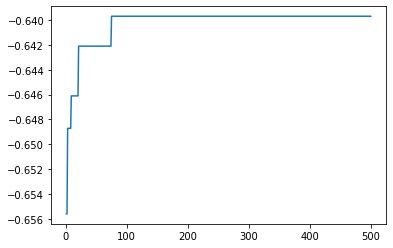

In [48]:
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['iter']
y = df_plot['loss_estimate']

plt.plot(x, best_value)
#plt.legend(title='Parameter where:')
plt.show()

In [54]:
df.to_csv('./output/bo_500_iter_batchSize_1.csv',index = None)